In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install torch nibabel torchinfo monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.8 MB/s eta 0:00:00


In [ ]:
pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 20.0 MB/s eta 0:00:00


In [ ]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm
import torchinfo

import zipfile
import random
import os

import torch
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch.utils.data import Dataset, DataLoader, random_split

from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchmetrics.functional import structural_similarity_index_measure
from monai.metrics import DiceMetric
from tqdm import tqdm
import matplotlib.pyplot as plt

**Model : Unet**



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
    dropout=0.2
).to(device)


In [ ]:
torchinfo.summary(model, input_size=(8, 1, 16,  128,  128))

Layer (type:depth-idx)                                                                Output Shape              Param #
UNet                                                                                  [8, 1, 16, 128, 128]      --
├─Sequential: 1-1                                                                     [8, 1, 16, 128, 128]      --
│    └─ResidualUnit: 2-1                                                              [8, 16, 8, 64, 64]        --
│    │    └─Conv3d: 3-1                                                               [8, 16, 8, 64, 64]        448
│    │    └─Sequential: 3-2                                                           [8, 16, 8, 64, 64]        7,442
│    └─SkipConnection: 2-2                                                            [8, 32, 8, 64, 64]        --
│    │    └─Sequential: 3-3                                                           [8, 16, 8, 64, 64]        4,799,182
│    └─Sequential: 2-3                                          

##Dataset : openBHB Dataset

In [ ]:
# Path to the zip file in your Google Drive
zip_file_path = '/content/drive/MyDrive/archive (9).zip'

# Destination path to extract files
destination_dir = '/content/dataset/'

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

# List the extracted files (optional)
os.listdir(destination_dir)


['official_site_class_labels.tsv', 'val_quasiraw']

In [ ]:
def split_data(source_dir, test_ratio=0.2, max_volumes=500):
    # Get a list of all volume files in the source directory
    volumes = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

    # Limit to the first 400 volumes
    volumes = volumes[:max_volumes]

    # Shuffle volumes randomly
    random.shuffle(volumes)

    # Calculate the split index
    split_index = int(len(volumes) * (1 - test_ratio))

    # Split volumes into train and test sets
    train_volumes = volumes[:split_index]
    test_volumes = volumes[split_index:]

    return train_volumes, test_volumes

# Usage example:
source_dir = "/content/dataset/val_quasiraw"
test_ratio = 0.1  # Adjust this to change the test/train split

train_volumes, test_volumes = split_data(source_dir, test_ratio, max_volumes=600)


print("Training set volumes:", len(train_volumes))
print("Testing set volumes:", len(test_volumes))


Training set volumes: 540
Testing set volumes: 60


In [ ]:
import os
import numpy as np
import torch

class BrainMRIDataset(Dataset):
    def __init__(self, base_path, volume_list, target_size=(88, 128, 128), slice_depth=16, transform=None):
        self.base_path = base_path
        self.volume_list = volume_list
        self.target_size = target_size
        self.slice_depth = slice_depth
        self.transform = transform

    def __len__(self):
        return len(self.volume_list)

    def crop(self, volume, start_y=20, end_y=160, start_x=20, end_x=196, start_z=50, end_z=130):
        cropped_volume = volume[start_z:end_z, start_y:end_y, start_x:end_x]
        return cropped_volume

    def get_slices(self, mri_volume):
        if len(mri_volume.shape) != 3:
            mri_volume = mri_volume.squeeze()

        patches = []
        num_slices = mri_volume.shape[0] // self.slice_depth

        for i in range(num_slices):
            start = i * self.slice_depth
            end = start + self.slice_depth
            patch = mri_volume[start:end, :, :]
            patches.append(patch)

        remainder = mri_volume.shape[0] % self.slice_depth
        if remainder > 0:
            patch = mri_volume[-self.slice_depth:, :, :]
            patches.append(patch)

        return patches

    def __getitem__(self, index):
        # Get the filename for the current volume
        volume_file = self.volume_list[index]

        # Construct the file path
        file_path = os.path.join(self.base_path, volume_file)

        # Load the .npy file
        mri_volume = np.load(file_path)  # Shape: (1, 1, 182, 218, 182)

        # Convert to tensor and remove redundant dimensions
        mri_volume = torch.tensor(mri_volume).float().squeeze().squeeze()  # Shape: [182, 218, 182]

        # (C, H, W, D ) - > (C, D, H, W)
        mri_volume = mri_volume.permute(2, 0, 1)

        # Crop to (80, 140, 176)
        mri_crop = self.crop(mri_volume)

        # Resize to target shape (128x128x128)
        mri_resize = F.interpolate(
            mri_crop.unsqueeze(0).unsqueeze(0),
            size=(mri_crop.shape[0], 128, 128),
            mode='trilinear',
            align_corners=False
        ).squeeze()

        # Normalize the volume
        mri_volume = (mri_resize - mri_resize.min()) / (mri_resize.max() - mri_resize.min() + 1e-8)

        # Slice the volume along the depth axis
        mri_slices = self.get_slices(mri_volume)

        # Add channel dimension back to each slice
        mri_slices = [slice.unsqueeze(0) for slice in mri_slices]  # Shape: [1, 128, 128, 8]

        return mri_slices


In [ ]:
# Initialize dataset
dataset = BrainMRIDataset(base_path='/content/dataset/val_quasiraw', volume_list=train_volumes)

# Test the dataset
volume_slices = dataset[0]
print(f"Dataset length : {len(dataset)}, Number of slices: {len(volume_slices)}, Slice shape: {volume_slices[0].shape}")

Dataset length : 540, Number of slices: 5, Slice shape: torch.Size([1, 16, 128, 128])


In [ ]:
class SliceDatasetFromList(Dataset):
    def __init__(self, patch_list):
        self.patch_list = [patch for sublist in patch_list for patch in sublist]

    def __len__(self):
        return len(self.patch_list)

    def __getitem__(self, index):
        patch = self.patch_list[index]
        patch_tensor = torch.tensor(patch).float()

        return patch_tensor, patch_tensor


Slices = SliceDatasetFromList(dataset)

train_ratio = 0.85
val_ratio = 0.15

train_size = int(train_ratio * len(Slices))
val_size = len(Slices) - train_size

train_dataset, val_dataset = random_split(Slices, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print("Train set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))


Train set size: 2295
Validation set size: 405


##Training

In [ ]:
criterion = monai.losses.SSIMLoss(spatial_dims=3)
# criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
print(device)

cuda


In [ ]:
def save_checkpoint(state, is_best, checkpoint_dir="/content/drive/MyDrive/checkpoint_UNET_ssim", filename="checkpoint_MSE_SSIM.pth"):
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    torch.save(state, checkpoint_path)
    if is_best:
        best_model_path = os.path.join(checkpoint_dir, "best_model_MSE_SSIM.pth")
        torch.save(state, best_model_path)
        print(f"Best model saved to {best_model_path}")


Epoch 1/50 (Training):   0%|          | 0/287 [00:00<?, ?it/s]<ipython-input-12-c55d1c16b718>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  patch_tensor = torch.tensor(patch).float()
Epoch 1/50 (Validation): 100%|██████████| 51/51 [00:02<00:00, 24.11it/s]


Epoch [1/50], Train Loss: 0.1802, Val Loss: 0.0612
Best model saved to /content/drive/MyDrive/checkpoint_UNET_ssim/best_model_MSE_SSIM.pth


Epoch 2/50 (Validation): 100%|██████████| 51/51 [00:02<00:00, 23.44it/s]


Epoch [2/50], Train Loss: 0.1708, Val Loss: 0.0645


Epoch 3/50 (Validation): 100%|██████████| 51/51 [00:02<00:00, 23.86it/s]


Epoch [3/50], Train Loss: 0.1663, Val Loss: 0.0558
Best model saved to /content/drive/MyDrive/checkpoint_UNET_ssim/best_model_MSE_SSIM.pth


Epoch 4/50 (Validation): 100%|██████████| 51/51 [00:02<00:00, 23.21it/s]


Epoch [4/50], Train Loss: 0.1635, Val Loss: 0.0561


Epoch 5/50 (Validation): 100%|██████████| 51/51 [00:02<00:00, 24.22it/s]


Epoch [5/50], Train Loss: 0.1615, Val Loss: 0.0535
Best model saved to /content/drive/MyDrive/checkpoint_UNET_ssim/best_model_MSE_SSIM.pth


Epoch 6/50 (Validation): 100%|██████████| 51/51 [00:02<00:00, 23.28it/s]


Epoch [6/50], Train Loss: 0.1601, Val Loss: 0.0558


Epoch 7/50 (Validation): 100%|██████████| 51/51 [00:02<00:00, 24.04it/s]


Epoch [7/50], Train Loss: 0.1590, Val Loss: 0.0535


Epoch 8/50 (Validation): 100%|██████████| 51/51 [00:02<00:00, 23.23it/s]


Epoch [8/50], Train Loss: 0.1581, Val Loss: 0.0493
Best model saved to /content/drive/MyDrive/checkpoint_UNET_ssim/best_model_MSE_SSIM.pth


Epoch 9/50 (Validation): 100%|██████████| 51/51 [00:02<00:00, 23.76it/s]


Epoch [9/50], Train Loss: 0.1577, Val Loss: 0.0446
Best model saved to /content/drive/MyDrive/checkpoint_UNET_ssim/best_model_MSE_SSIM.pth


Epoch 10/50 (Validation): 100%|██████████| 51/51 [00:02<00:00, 23.38it/s]


Epoch [10/50], Train Loss: 0.1565, Val Loss: 0.0510


Epoch 11/50 (Validation): 100%|██████████| 51/51 [00:02<00:00, 24.02it/s]


Epoch [11/50], Train Loss: 0.1562, Val Loss: 0.0529


Epoch 12/50 (Validation): 100%|██████████| 51/51 [00:02<00:00, 23.39it/s]


Epoch [12/50], Train Loss: 0.1554, Val Loss: 0.0475


Epoch 13/50 (Validation): 100%|██████████| 51/51 [00:02<00:00, 23.88it/s]


Epoch [13/50], Train Loss: 0.1556, Val Loss: 0.0506


Epoch 14/50 (Validation): 100%|██████████| 51/51 [00:02<00:00, 23.31it/s]


Epoch [14/50], Train Loss: 0.1547, Val Loss: 0.0502


Epoch 15/50 (Validation): 100%|██████████| 51/51 [00:02<00:00, 24.03it/s]


Epoch [15/50], Train Loss: 0.1547, Val Loss: 0.0497


Epoch 16/50 (Validation): 100%|██████████| 51/51 [00:02<00:00, 23.52it/s]


Epoch [16/50], Train Loss: 0.1545, Val Loss: 0.0510


Epoch 17/50 (Validation): 100%|██████████| 51/51 [00:02<00:00, 24.19it/s]


Epoch [17/50], Train Loss: 0.1538, Val Loss: 0.0530


Epoch 18/50 (Validation): 100%|██████████| 51/51 [00:02<00:00, 23.59it/s]


Epoch [18/50], Train Loss: 0.1536, Val Loss: 0.0610


Epoch 19/50 (Validation): 100%|██████████| 51/51 [00:02<00:00, 24.27it/s]


Epoch [19/50], Train Loss: 0.1535, Val Loss: 0.0556
Early stopping at epoch 19. No improvement in validation loss for 10 consecutive epochs.
Best Validation Loss: 0.0446


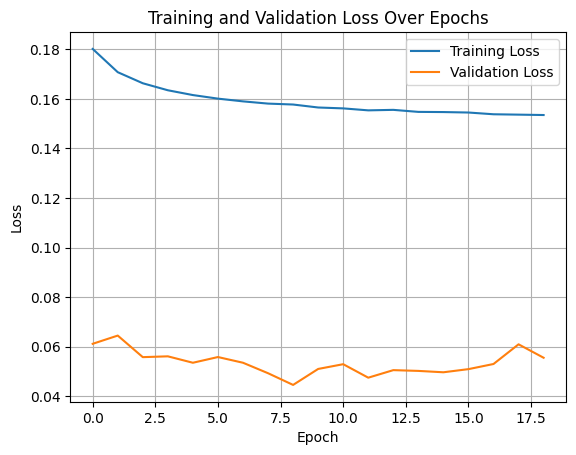

In [ ]:
import torch
import monai
from monai.losses import SSIMLoss


train_loss_values = []
val_loss_values = []

num_epochs = 50
best_val_loss = float('inf')
patience = 10
early_stop_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # Training loop
    for imgs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Training)'):
        imgs, targets = imgs.to(device), targets.to(device)
        optimizer.zero_grad()  # Clear gradients
        outputs = model(imgs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        train_loss += loss.item()

    # Average training loss for this epoch
    train_loss /= len(train_loader)
    train_loss_values.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, targets in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Validation)'):
            imgs, targets = imgs.to(device), targets.to(device)
            outputs = model(imgs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute validation loss
            val_loss += loss.item()  # Accumulate validation loss

    # Average validation loss for this epoch
    val_loss /= len(val_loader)
    val_loss_values.append(val_loss)

    # Print the losses for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss
        early_stop_counter = 0

        # Save the best model checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }
        save_checkpoint(checkpoint, is_best)  # Ensure save_checkpoint function is defined
    else:
        early_stop_counter += 1

    # Early stopping condition
    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. No improvement in validation loss for {patience} consecutive epochs.")
        break

# Print the best validation loss
print(f"Best Validation Loss: {best_val_loss:.4f}")

# Plotting the loss
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()


In [ ]:
torch.save(model.state_dict(), '3d_MonaiUNET_slices_MSE.pth')

In [ ]:
dataset_test = BrainMRIDataset(base_path='/content/dataset/val_quasiraw', volume_list=test_volumes)

Slices_test = SliceDatasetFromList(dataset_test)

test_loader = DataLoader(Slices_test, batch_size=8)


Testing:   0%|          | 0/38 [00:00<?, ?it/s]<ipython-input-12-c55d1c16b718>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  patch_tensor = torch.tensor(patch).float()


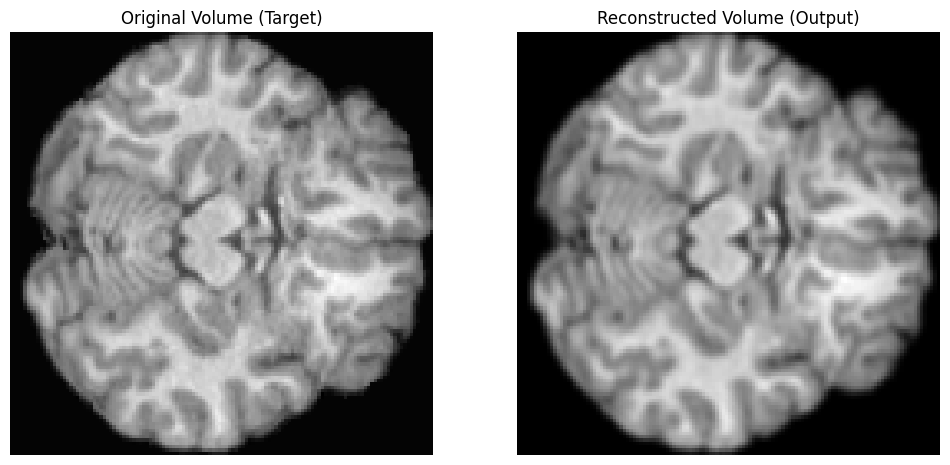

Testing:   3%|▎         | 1/38 [00:00<00:12,  2.97it/s]

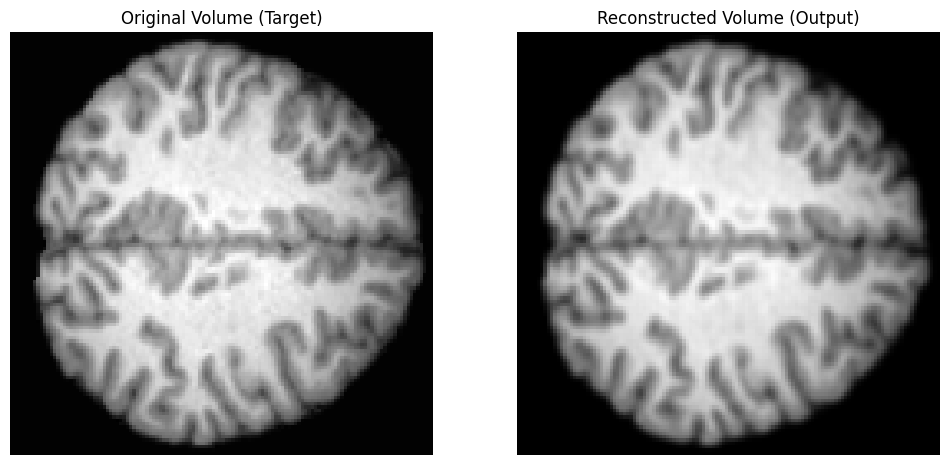

Testing:   5%|▌         | 2/38 [00:00<00:12,  2.91it/s]

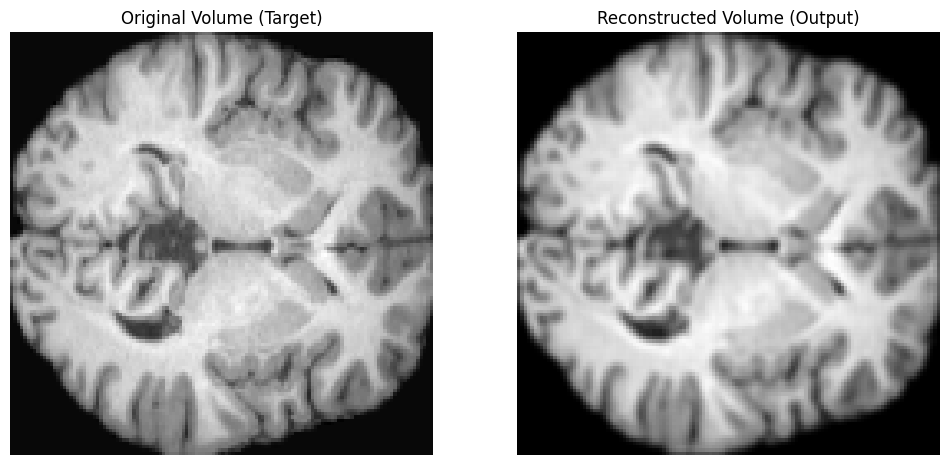

Testing:   8%|▊         | 3/38 [00:01<00:12,  2.85it/s]

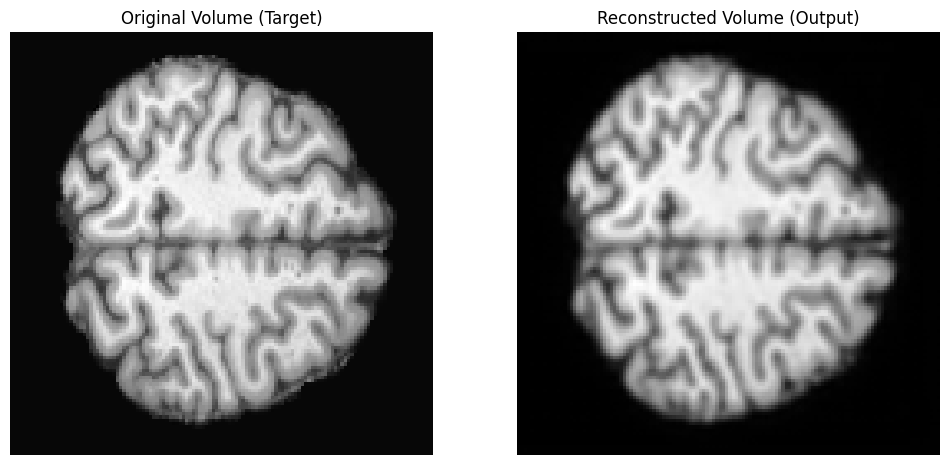

Testing:  11%|█         | 4/38 [00:01<00:11,  3.00it/s]

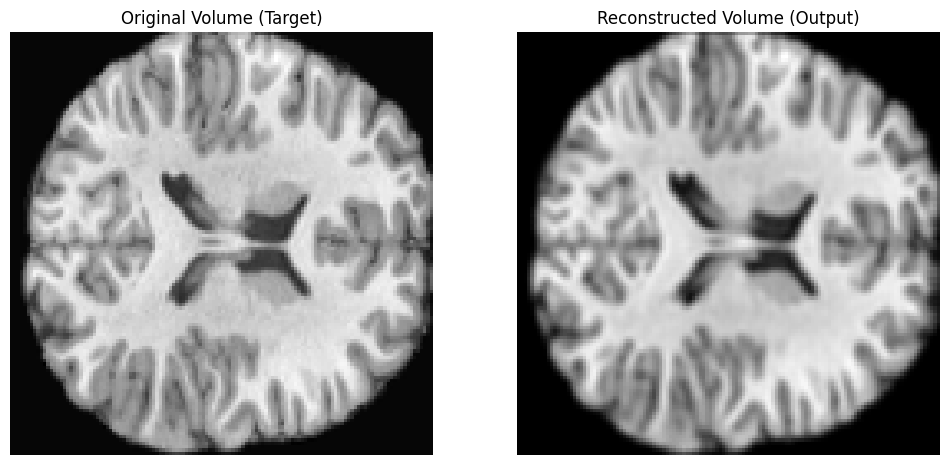

Testing:  13%|█▎        | 5/38 [00:01<00:10,  3.08it/s]

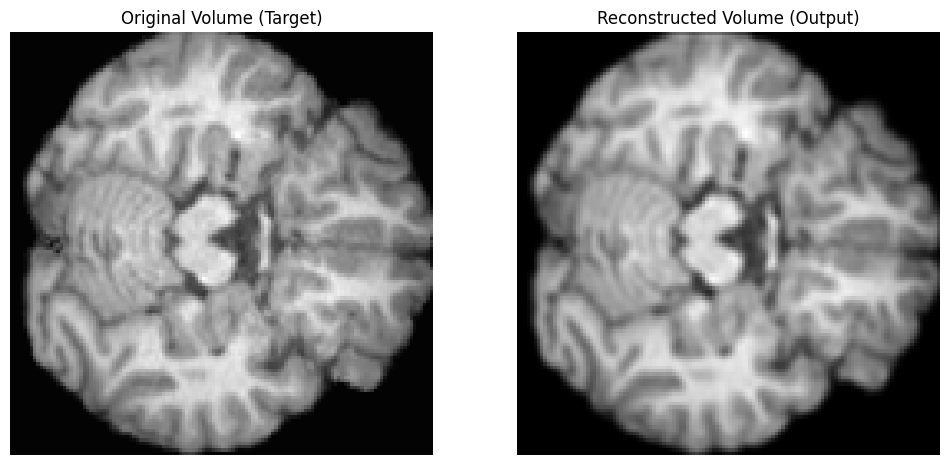

Testing:  16%|█▌        | 6/38 [00:01<00:10,  3.10it/s]

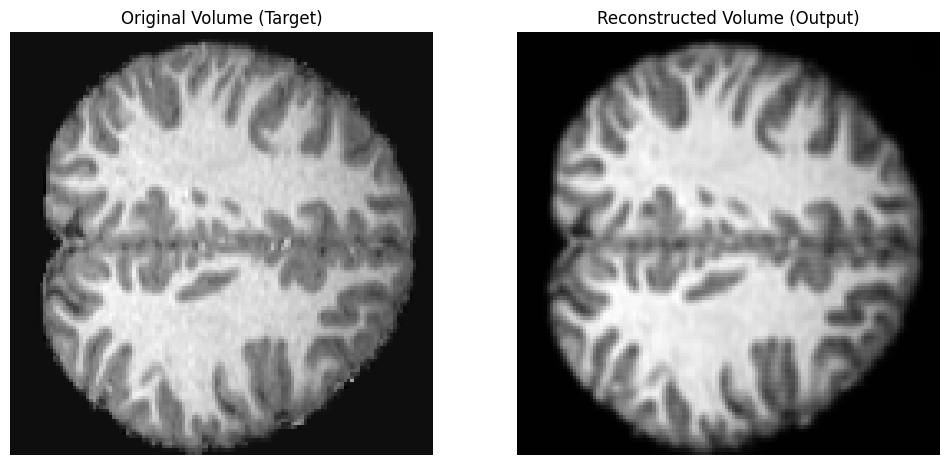

Testing:  18%|█▊        | 7/38 [00:02<00:10,  2.90it/s]

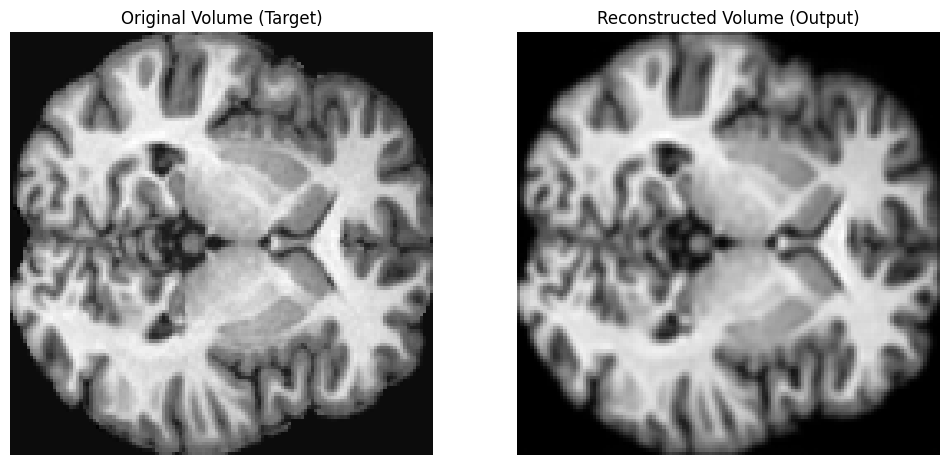

Testing:  21%|██        | 8/38 [00:02<00:10,  2.84it/s]

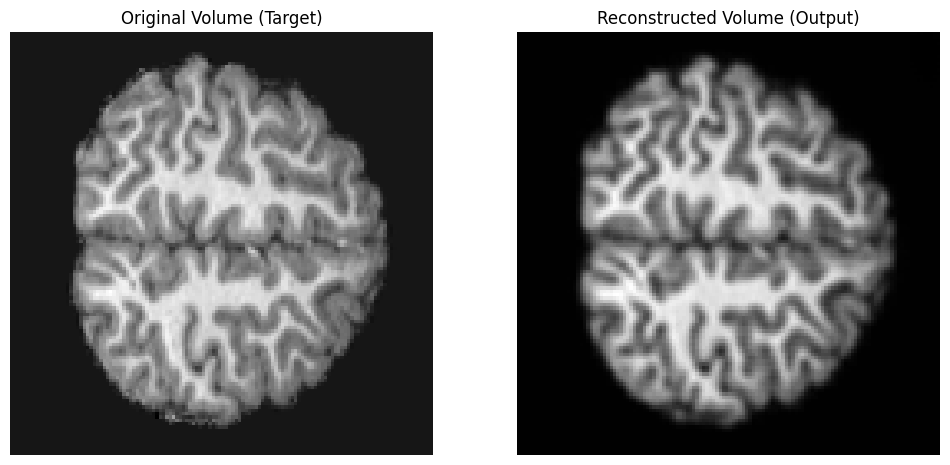

Testing:  24%|██▎       | 9/38 [00:03<00:10,  2.83it/s]

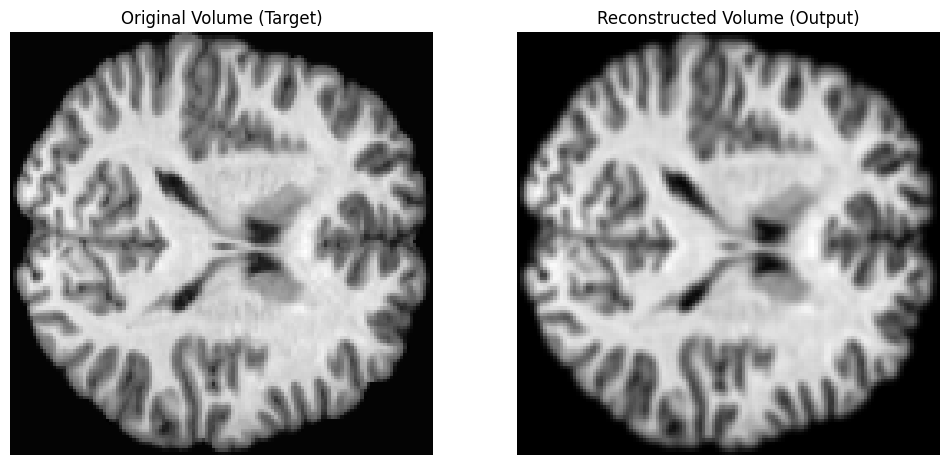

Testing:  26%|██▋       | 10/38 [00:03<00:09,  2.90it/s]

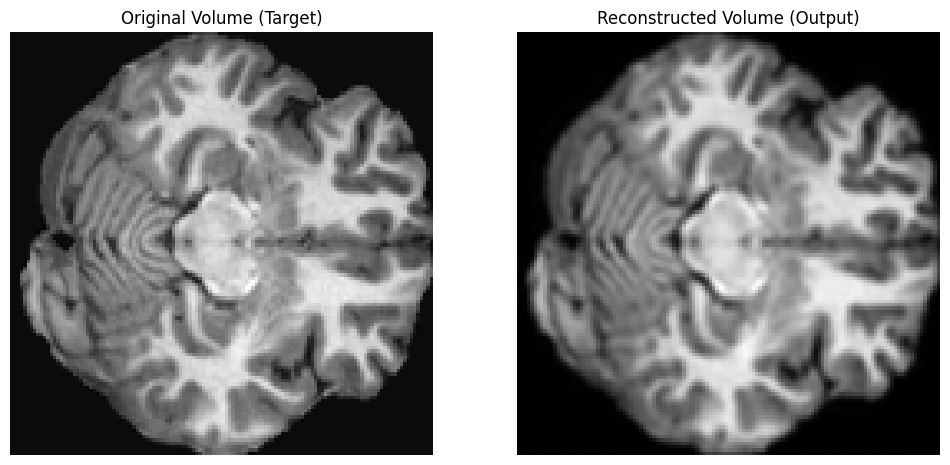

Testing:  29%|██▉       | 11/38 [00:03<00:09,  2.92it/s]

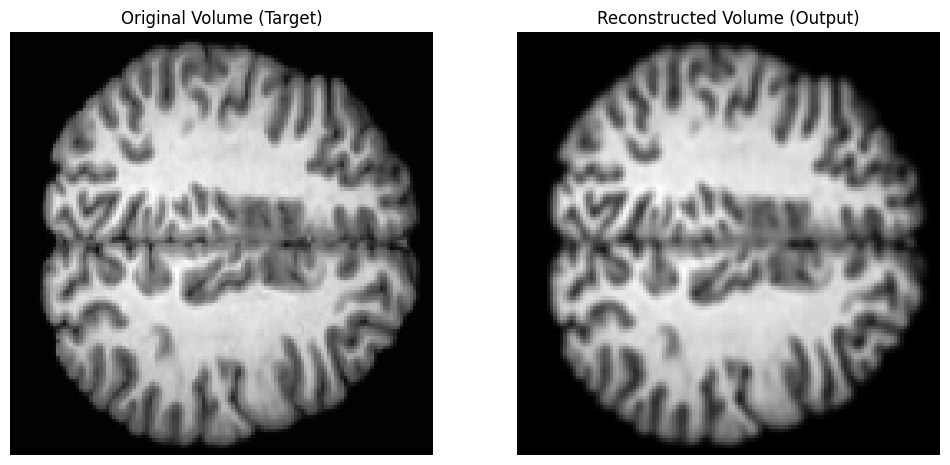

Testing:  32%|███▏      | 12/38 [00:04<00:08,  3.15it/s]

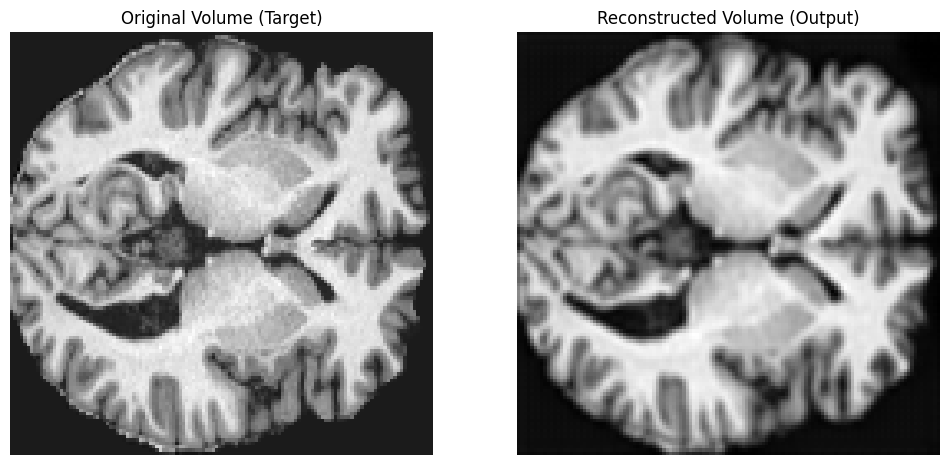

Testing:  34%|███▍      | 13/38 [00:04<00:07,  3.34it/s]

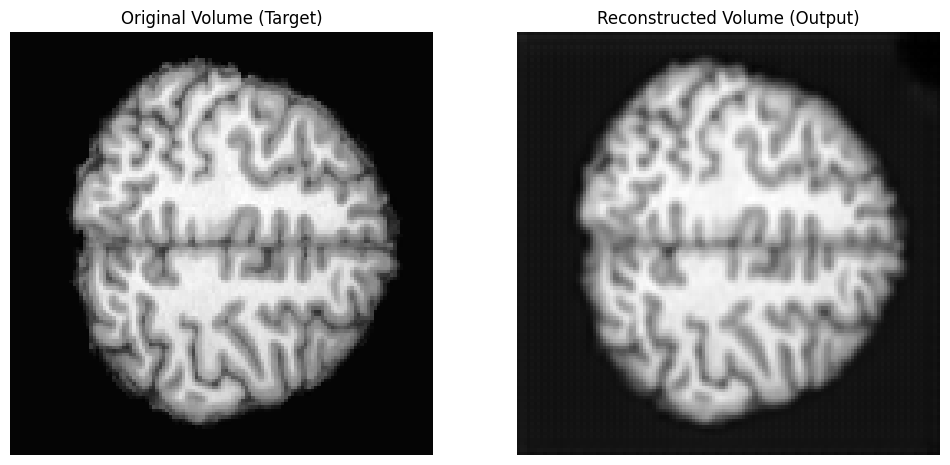

Testing:  37%|███▋      | 14/38 [00:04<00:07,  3.33it/s]

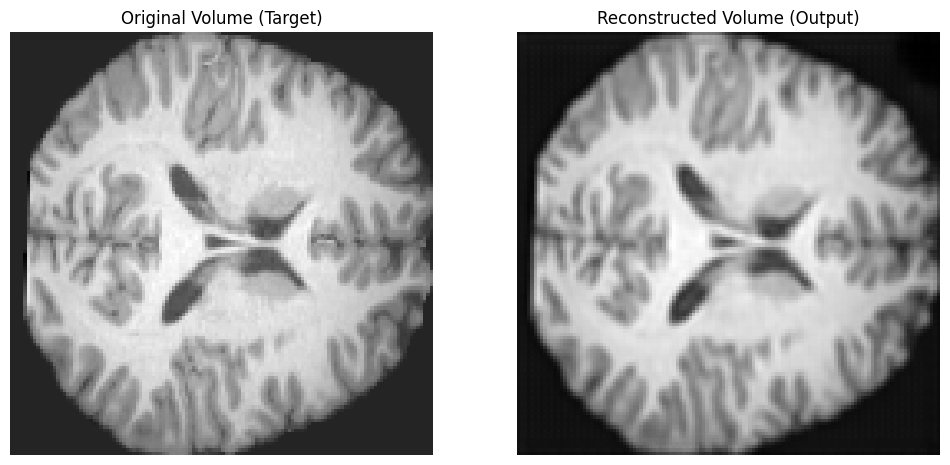

Testing:  39%|███▉      | 15/38 [00:04<00:06,  3.48it/s]

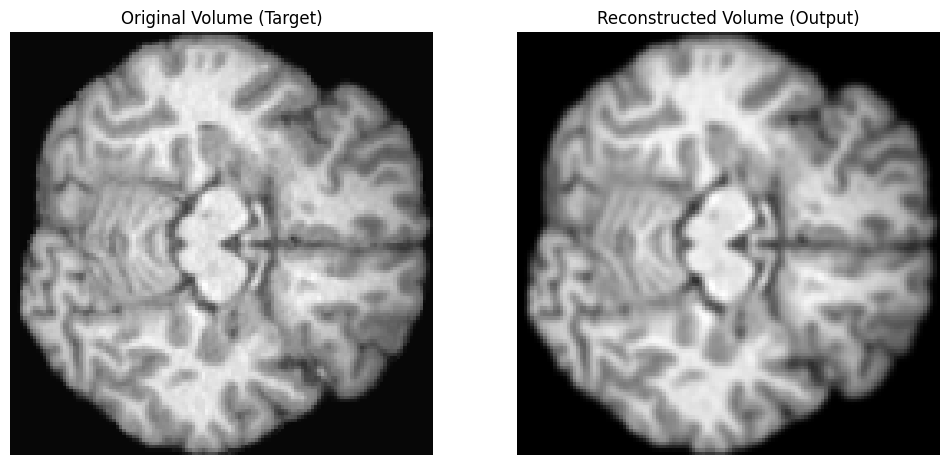

Testing:  42%|████▏     | 16/38 [00:05<00:08,  2.61it/s]

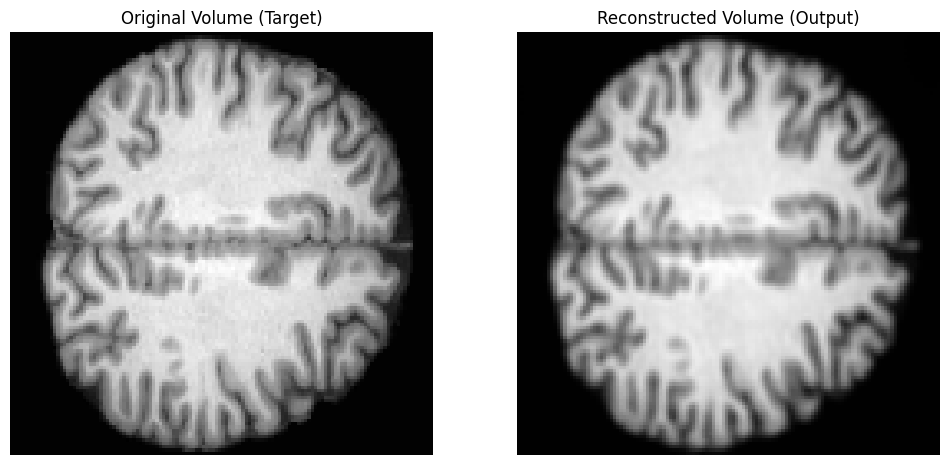

Testing:  45%|████▍     | 17/38 [00:05<00:07,  2.96it/s]

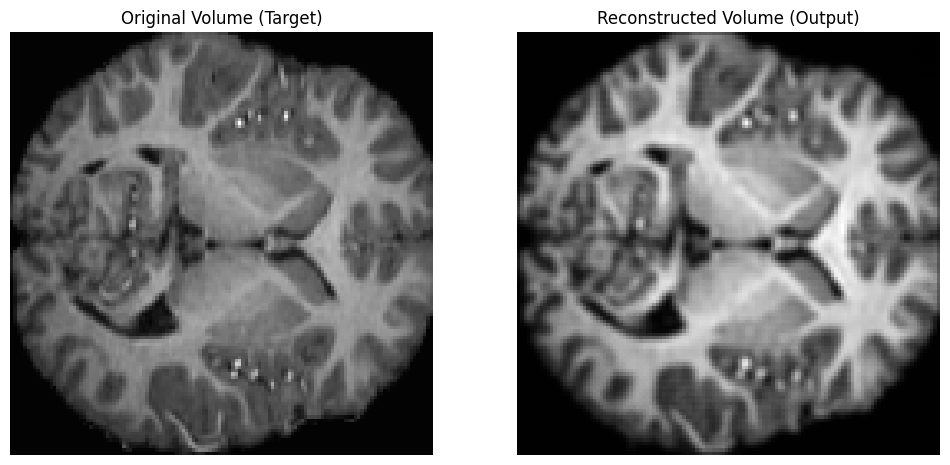

Testing:  47%|████▋     | 18/38 [00:05<00:06,  3.23it/s]

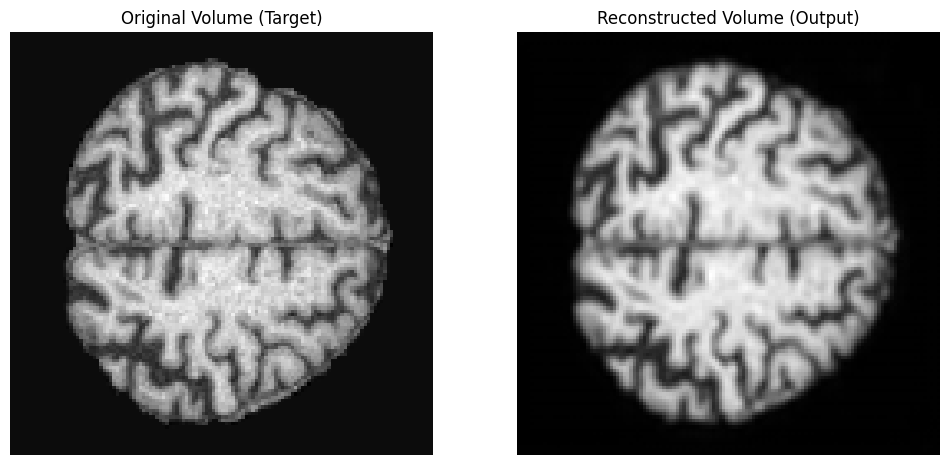

Testing:  50%|█████     | 19/38 [00:06<00:05,  3.42it/s]

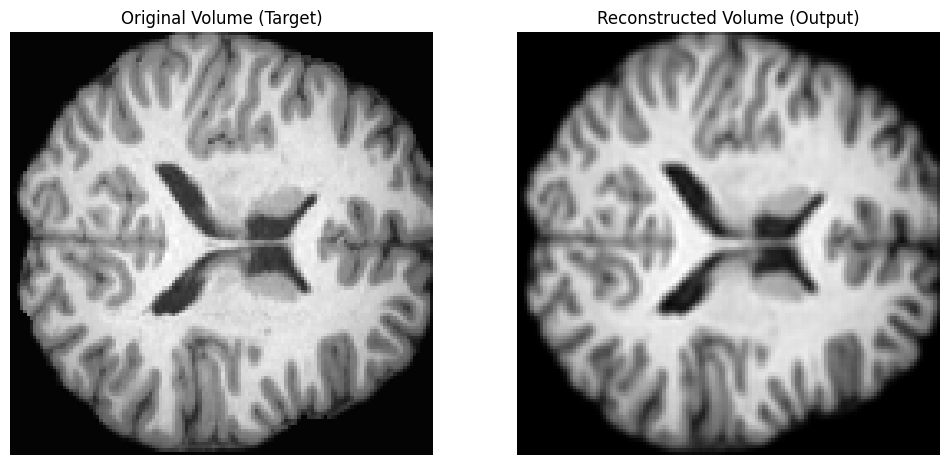

Testing:  53%|█████▎    | 20/38 [00:06<00:05,  3.54it/s]

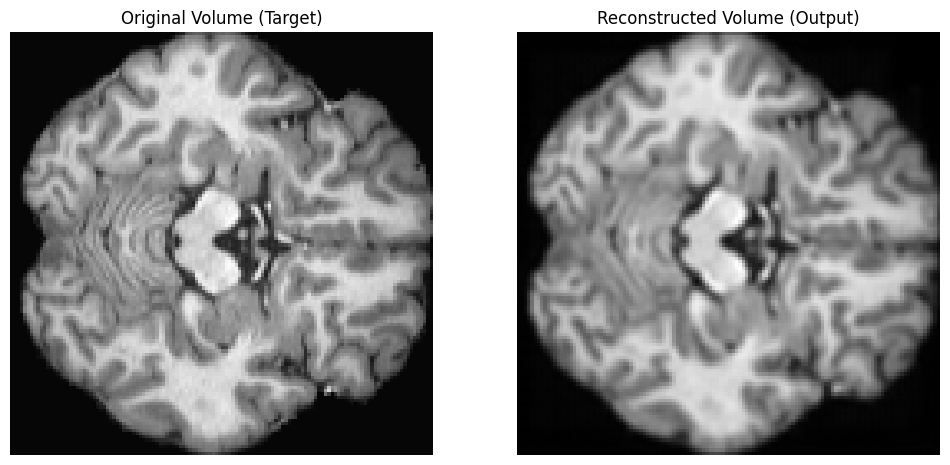

Testing:  55%|█████▌    | 21/38 [00:06<00:04,  3.70it/s]

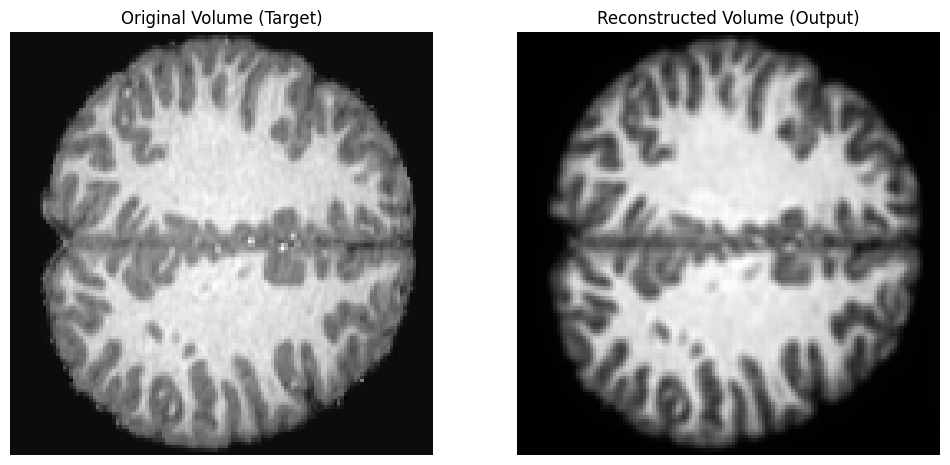

Testing:  58%|█████▊    | 22/38 [00:06<00:04,  3.81it/s]

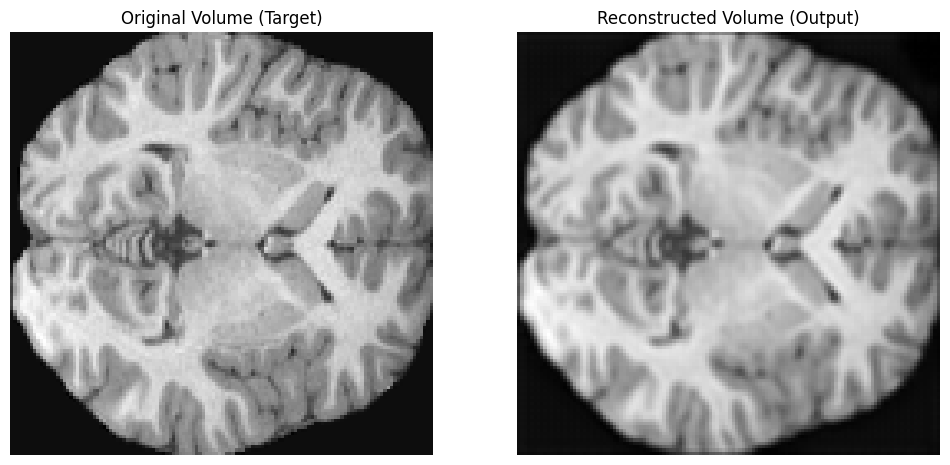

Testing:  61%|██████    | 23/38 [00:07<00:03,  3.91it/s]

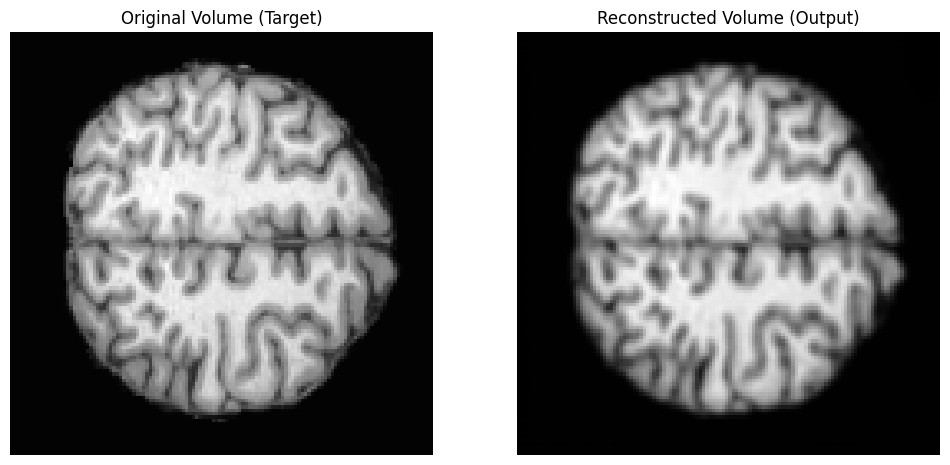

Testing:  63%|██████▎   | 24/38 [00:07<00:03,  3.89it/s]

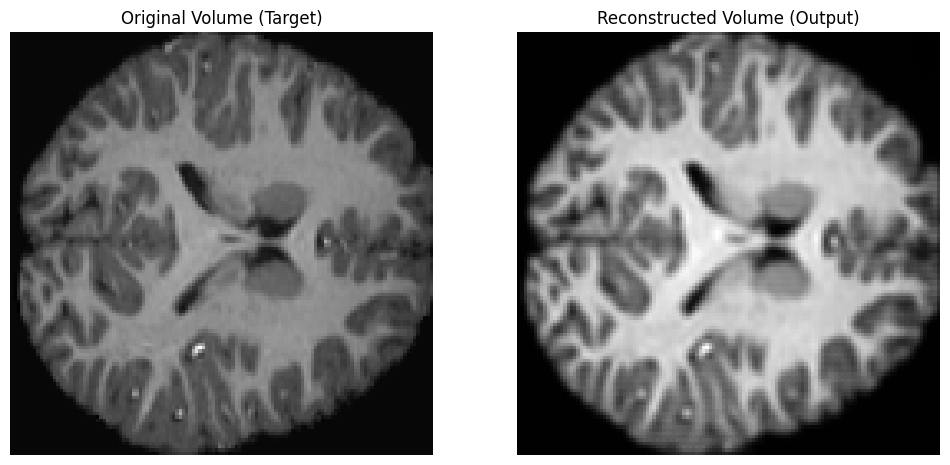

Testing:  66%|██████▌   | 25/38 [00:07<00:03,  3.97it/s]

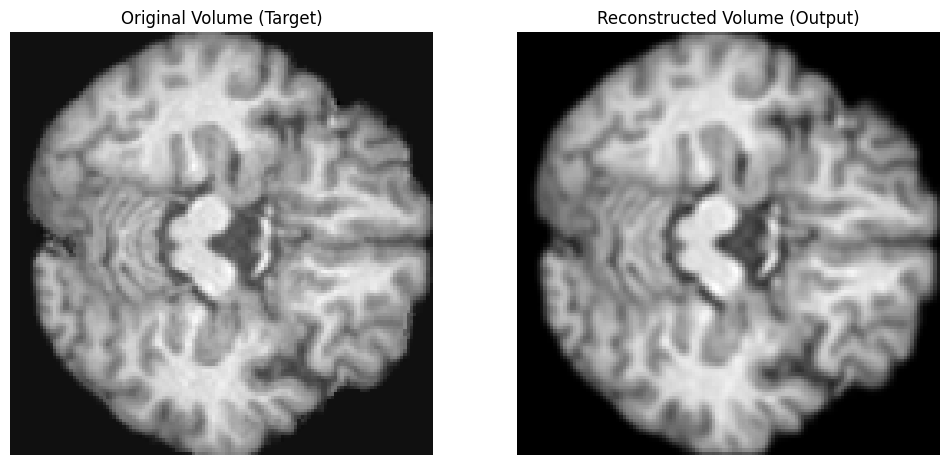

Testing:  68%|██████▊   | 26/38 [00:07<00:03,  3.93it/s]

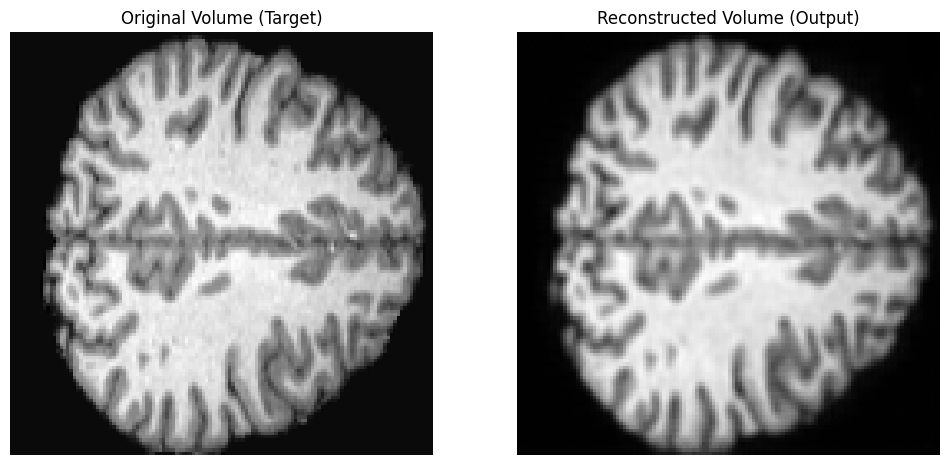

Testing:  71%|███████   | 27/38 [00:08<00:02,  3.95it/s]

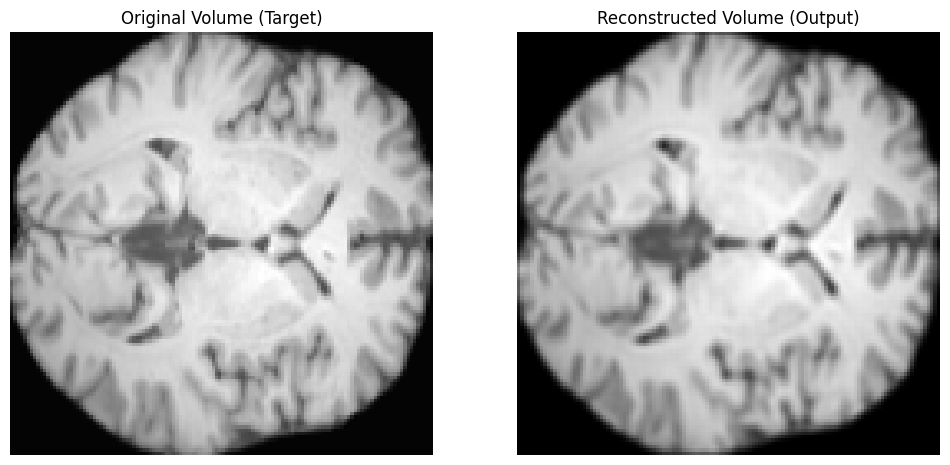

Testing:  74%|███████▎  | 28/38 [00:08<00:02,  3.92it/s]

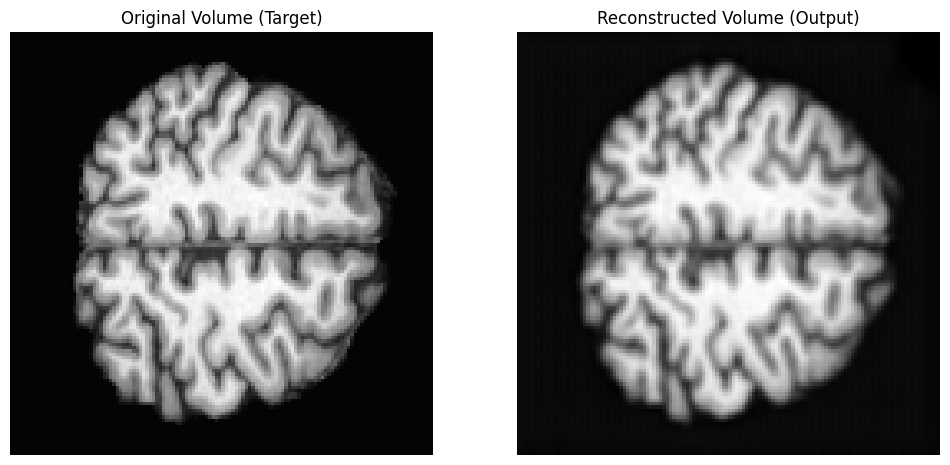

Testing:  76%|███████▋  | 29/38 [00:08<00:02,  3.91it/s]

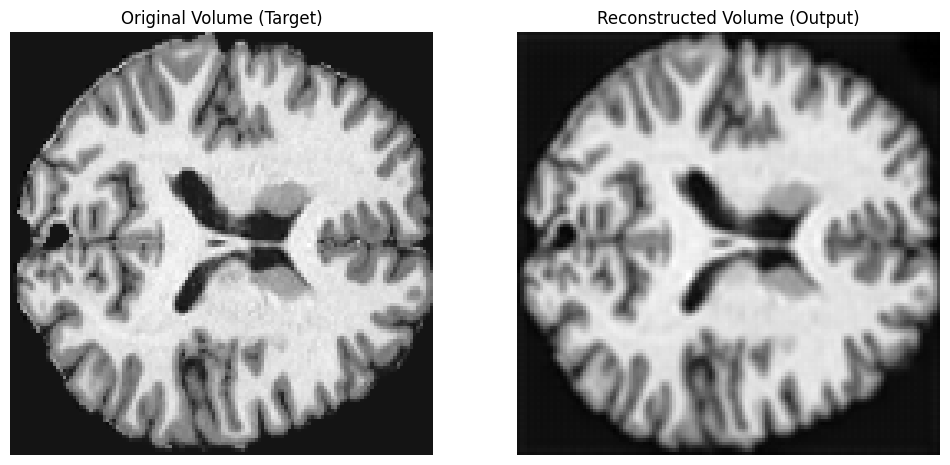

Testing:  79%|███████▉  | 30/38 [00:08<00:02,  3.95it/s]

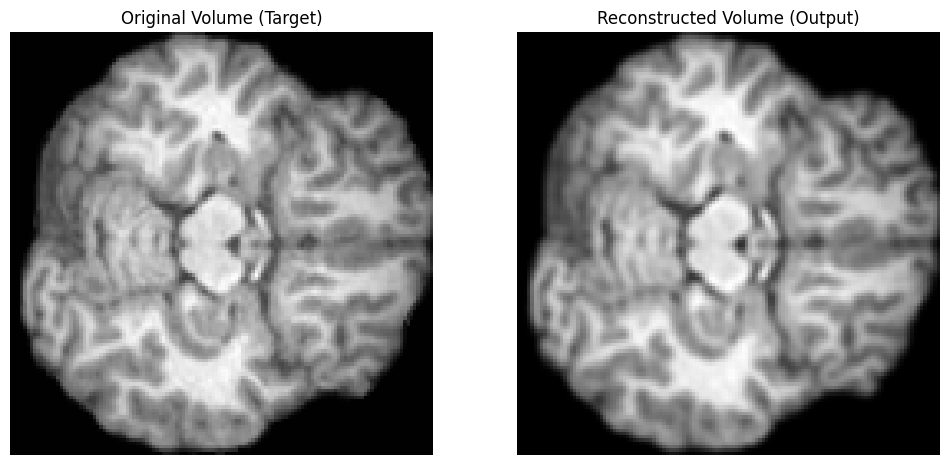

Testing:  82%|████████▏ | 31/38 [00:09<00:01,  3.97it/s]

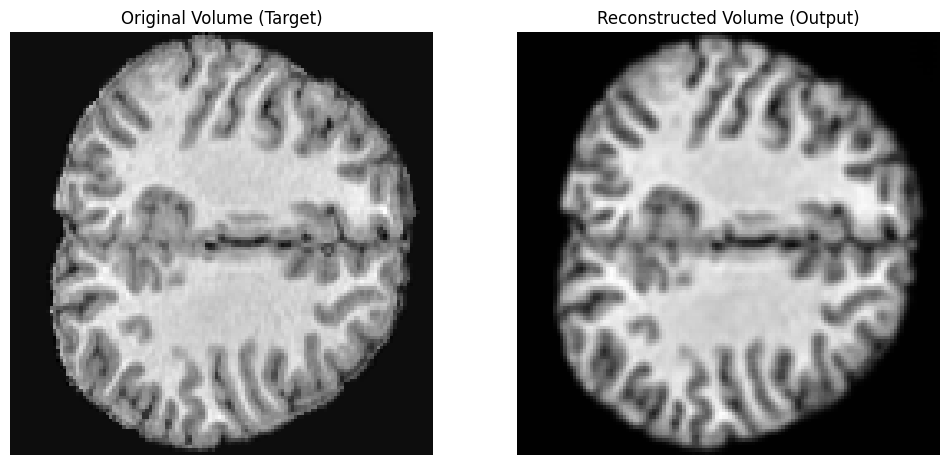

Testing:  84%|████████▍ | 32/38 [00:09<00:01,  3.87it/s]

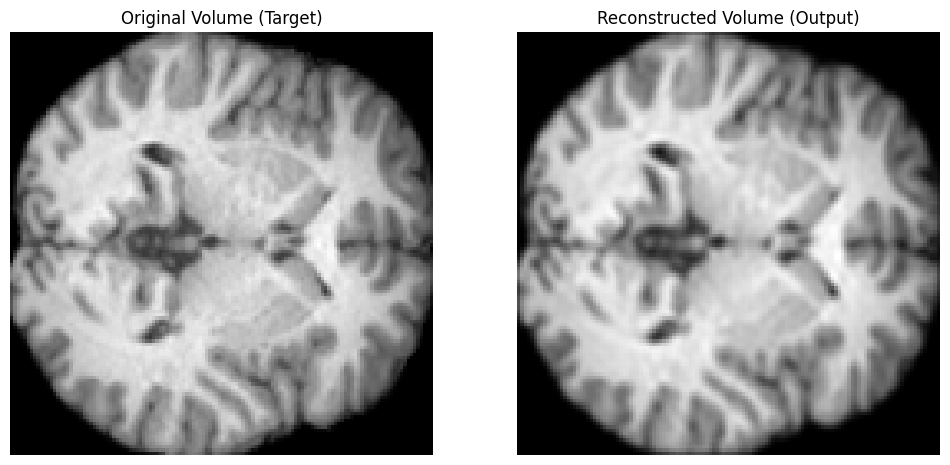

Testing:  87%|████████▋ | 33/38 [00:09<00:01,  3.93it/s]

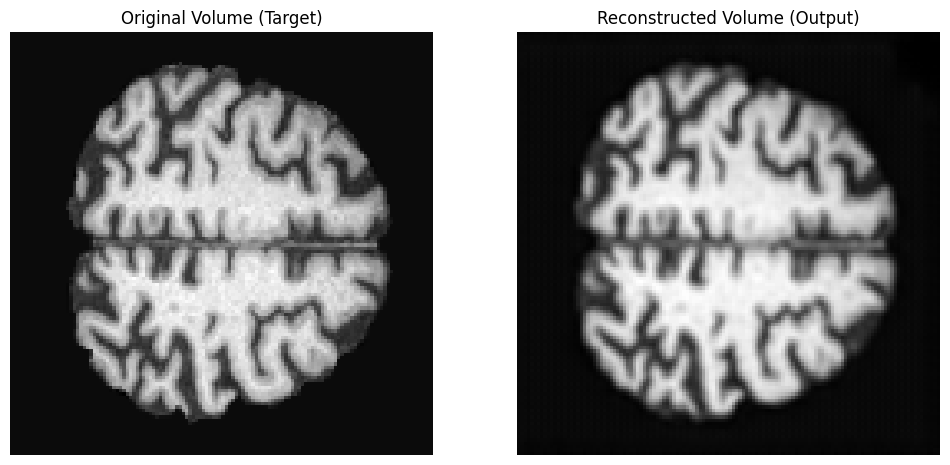

Testing:  89%|████████▉ | 34/38 [00:09<00:01,  3.91it/s]

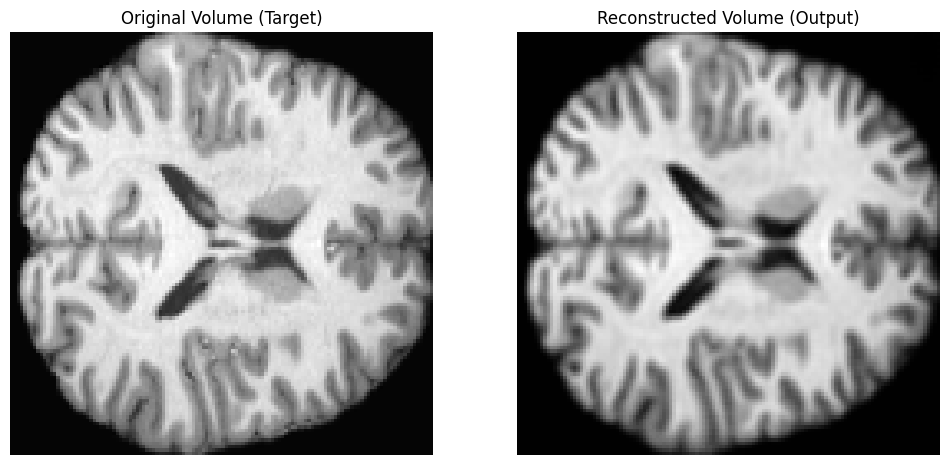

Testing:  92%|█████████▏| 35/38 [00:10<00:00,  3.94it/s]

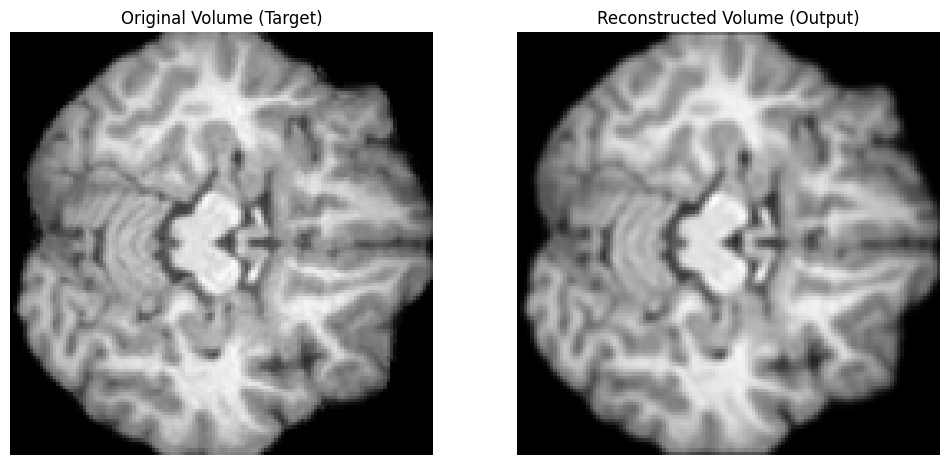

Testing:  95%|█████████▍| 36/38 [00:10<00:00,  3.88it/s]

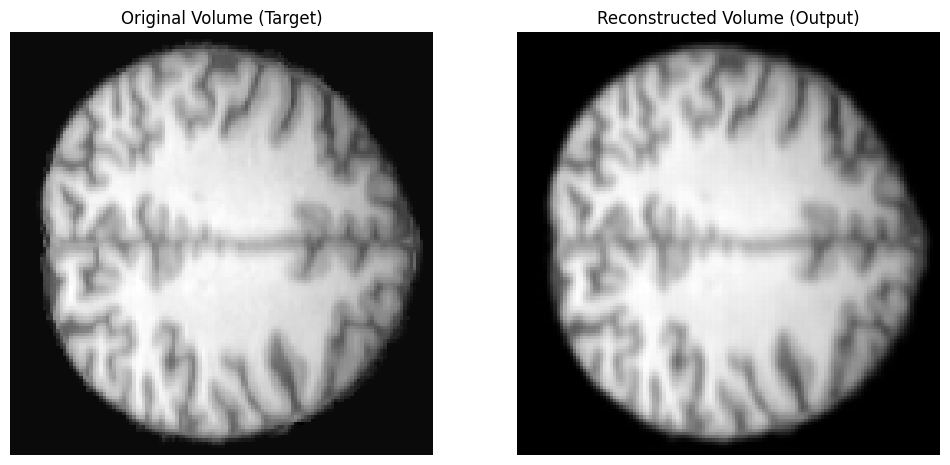

Testing:  97%|█████████▋| 37/38 [00:10<00:00,  3.93it/s]

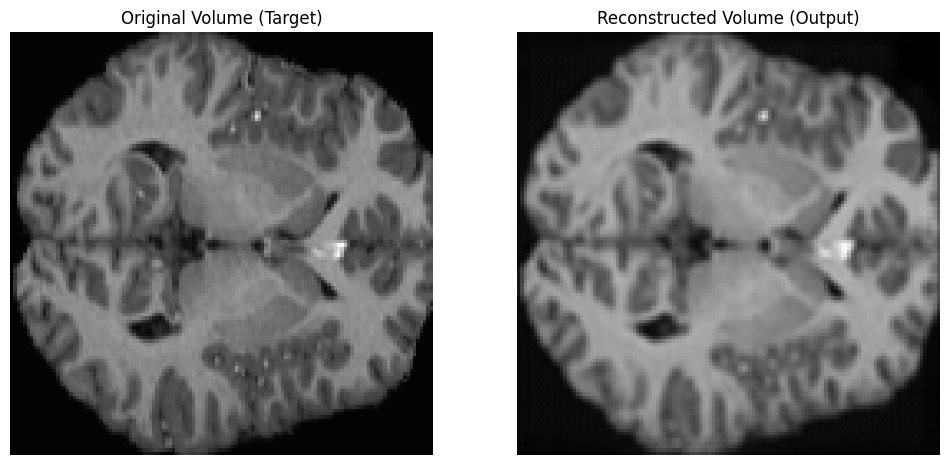

Testing: 100%|██████████| 38/38 [00:10<00:00,  3.47it/s]

Average Test Loss: 0.0006


In [ ]:
import matplotlib.pyplot as plt

# Test loop
test_loss = 0.0

with torch.no_grad():  # Disable gradient calculations for testing
    for imgs, targets in tqdm(test_loader, desc='Testing'):
        imgs, targets = imgs.to(device), targets.to(device)  # Move data to GPU
        outputs = model(imgs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute test loss
        test_loss += loss.item()  # Accumulate test loss

        # Visualize the input and reconstructed volume at depth 8
        depth = 8
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        # Original Volume (Target)
        ax[0].imshow(targets[0, 0, depth, :, :].cpu().numpy(), cmap='gray')
        ax[0].set_title('Original Volume (Target)')
        ax[0].axis('off')

        # Reconstructed Volume (Output)
        ax[1].imshow(outputs[0, 0, depth, :, :].cpu().numpy(), cmap='gray')
        ax[1].set_title('Reconstructed Volume (Output)')
        ax[1].axis('off')

        plt.show()  # Display the plot

# Average test loss
test_loss /= len(test_loader)
print(f"Average Test Loss: {test_loss:.4f}")
